### CBRFC + CNRFC

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import os
import netCDF4
import cartopy
from pyproj import CRS, Proj, transform, Transformer
import numpy as np
import mapclassify
import pysal
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import string
from matplotlib.collections import PatchCollection

/apps/geopython/1.0.1/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [2]:
all_damages=gpd.read_file(r'/blue/emullens/meirahwilliamson/StormData_RFC/StormData.shp')
all_damages=all_damages.dropna()[~all_damages.dropna()['episode_na'].str.contains('Harvey|harvey')]
all_damages=all_damages[~~(all_damages['flood_caus']!='Dam / Levee Break')]

missed=gpd.read_file(r'/blue/emullens/meirahwilliamson/missed_StormData/missed_individual_RFC/missed_individual_RFC.shp')


In [8]:
missed['flood_caus'].unique()

array(['Heavy Rain', 'Heavy Rain / Burn Area', 'Dam / Levee Break',
       'Heavy Rain / Tropical System', 'Ice Jam',
       'Heavy Rain / Snow Melt'], dtype=object)

In [41]:
#county pop for later
county_pop_csv=pd.read_csv(r'/blue/emullens/meirahwilliamson/county_pop.csv')
county_pop_csv['GEOID']=county_pop_csv['GEOID'].astype(str).str.zfill(5)
#alabama state geoid is 01001 not 01000, so delete alabama (first row)
county_pop_csv=county_pop_csv.iloc[1:,:]

counties=gpd.read_file(r'/blue/emullens/meirahwilliamson/Shapefiles/US_Counties/US_Counties.shp')
counties=counties.to_crs(3857)

In [42]:
river_basins=sorted(['MBRFC', 'WGRFC', 'OHRFC', 'LMRFC', 'NWRFC', 'CNRFC', 'CBRFC',
       'ABRFC', 'SERFC', 'NERFC', 'NCRFC', 'MARFC'])

In [43]:
missed[(missed['BASIN_ID']=='CNRFC') |(missed['BASIN_ID']=='CBRFC')]['property_d'].sum()

77366500.0

In [44]:
all_damages[(all_damages['BASIN_ID']=='CNRFC') |(all_damages['BASIN_ID']=='CBRFC')]['property_d'].sum()

172513200.0

In [10]:
missed=missed[(missed['flood_caus']!='Dam / Levee Break')]
missed

,GEOID,NAME,Shape_Leng,Shape_Area,Unnamed_ 0,date,property_d,month,flood_caus,season,episode_id,episode_na,index_righ,SITE_ID,STATE,RFC_NAME,RFC_CITY,BASIN_ID,geometry
0,20023,Cheyenne,2.145898,0.277464,3405.0,20200723.0,100.0,7.0,Heavy Rain,jja,150419.0,A cluster of stationary thunderstorms producin...,1.0,KRF,MO,Missouri Basin,Kansas City/Pleasant Hill,MBRFC,"POLYGON ((-11360348.177 4866389.576, -11335904..."
1,08125,Yuma,3.219391,0.649873,3404.0,20200723.0,100.0,7.0,Heavy Rain,jja,150990.0,A stationary thunderstorm producing prolonged ...,1.0,KRF,MO,Missouri Basin,Kansas City/Pleasant Hill,MBRFC,"POLYGON ((-11444062.994 4866313.427, -11442929..."
2,31057,Dundy,2.148325,0.252344,3407.0,20200723.0,100000.0,7.0,Heavy Rain,jja,150418.0,A cluster of thunderstorms became stationary o...,1.0,KRF,MO,Missouri Basin,Kansas City/Pleasant Hill,MBRFC,"POLYGON ((-11360299.753 4915237.416, -11360299..."
3,48415,Scurry,1.905973,0.226279,3409.0,20200723.0,1000.0,7.0,Heavy Rain,jja,150060.0,Moisture and instability were fairly high with...,22.0,FWR,TX,West Gulf,Dallas/Fort Worth,WGRFC,"POLYGON ((-11262568.921 3890473.070, -11247572..."
4,35027,Lincoln,5.382775,1.217482,3454.0,20200805.0,10000.0,8.0,Heavy Rain / Burn Area,jja,149299.0,A backdoor cold front that moved into eastern ...,22.0,FWR,TX,West Gulf,Dallas/Fort Worth,WGRFC,"POLYGON ((-11841461.665 3983306.597, -11805734..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
810,48439,Tarrant,1.903721,0.224588,2954.0,20200110.0,7000.0,1.0,Heavy Rain,djf,145409.0,A deep upper level trough and a humid and unst...,22.0,FWR,TX,West Gulf,Dallas/Fort Worth,WGRFC,"POLYGON ((-10858568.559 3894531.083, -10842349..."
811,28121,Rankin,1.853711,0.200166,1021.0,20180207.0,10000.0,2.0,Heavy Rain,djf,121962.0,Showers and thunderstorms developed as a cold ...,5.0,ORN,LA,Lower Mississippi,New Orleans/Baton Rouge,LMRFC,"POLYGON ((-10047118.266 3783172.804, -10040445..."
812,28099,Neshoba,1.515104,0.142622,1020.0,20180207.0,1000.0,2.0,Heavy Rain,djf,121962.0,Showers and thunderstorms developed as a cold ...,5.0,ORN,LA,Lower Mississippi,New Orleans/Baton Rouge,LMRFC,"POLYGON ((-9942963.743 3886235.685, -9909407.5..."
813,47073,Hawkins,1.757308,0.129626,2010.0,20190207.0,2000.0,2.0,Heavy Rain,djf,135168.0,"A warm, moist, Gulf air mass was in place acro...",5.0,ORN,LA,Lower Mississippi,New Orleans/Baton Rouge,LMRFC,"POLYGON ((-9270753.428 4355066.761, -9252983.6..."


In [36]:
missed[missed['season']=='mam']['property_d'].sum()/missed[missed['season']=='mam']['GEOID'].nunique()

665330.2702702703

### All RFCs

fraction of damages: 0.09192298495603583


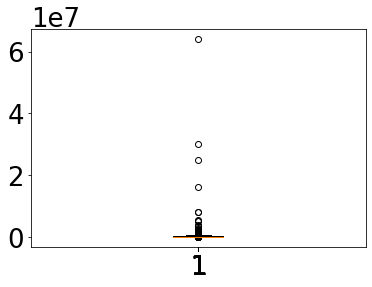

In [186]:
missed_=0
all_=0
county_=0

damage_df=pd.DataFrame(columns=['BASIN_ID','property_d','damage_percent'])

for river_basin in river_basins:
    river_basin_missed=missed[(missed['BASIN_ID']==river_basin)].dropna()
    river_basin_all=all_damages[(all_damages['BASIN_ID']==river_basin)].dropna()

    county_pop=counties[(counties['BASIN_ID_l']==river_basin)].dropna()
    missed_+=river_basin_missed['property_d'].sum()
    all_+=river_basin_all['property_d'].sum()
    county_=county_pop['POPESTIM_3'].sum()
    damages_event_pct=len(river_basin_missed['property_d'])/len(river_basin_all['property_d'])
    damages_pct=river_basin_missed['property_d'].sum()/river_basin_all['property_d'].sum()
    damage_pop=river_basin_missed['property_d'].sum()/county_pop['POPESTIM_3'].sum()
    unique_geoid=river_basin_missed['GEOID'].unique()
    unique_geoid_all=river_basin_all['GEOID'].unique()
    county_pop_counties=county_pop_csv[county_pop_csv['GEOID'].isin(unique_geoid)]['POPESTIMATE2019'].sum()
    county_pop_counties_all=county_pop_csv[county_pop_csv['GEOID'].isin(unique_geoid_all)]['POPESTIMATE2019'].sum()
    damage_pop_select_counties=river_basin_missed['property_d'].sum()/county_pop_counties
    damage_pop_select_counties_all=river_basin_all['property_d'].sum()/county_pop_counties_all
    damage_per_event=river_basin_missed['property_d'].sum()/river_basin_missed['property_d'].count()

    plt.boxplot(river_basin_missed['property_d'])
    
    damage_df=damage_df.append({'BASIN_ID':river_basin,'property_d':river_basin_missed['property_d'].sum(),'no_events':len(river_basin_missed),
                                'damages_event_percent':damages_event_pct,'damage_percent':damages_pct,'county_pop':county_pop_counties,'damage_pop':damage_pop,
                                'dp_select_counties':damage_pop_select_counties,'dp_select_counties_all':damage_pop_select_counties_all,'damage_per_event':damage_per_event},ignore_index=True)
    
print('fraction of damages:', missed_/all_)

In [188]:
damage_df['property_d'].sum()/all_damages['property_d'].sum()

0.09192298495603583

In [189]:
len(missed)/len(all_damages)

0.23191733639494833

In [190]:
damage_df['property_d'].sum()/damage_df['county_pop'].sum()

2.552004690864895

In [191]:
river=gpd.read_file(r'/blue/emullens/meirahwilliamson/rf12ja05/rf12ja05.shp')
river=river.to_crs(epsg=3857)

riv_merge=river.merge(damage_df,on='BASIN_ID')

In [21]:
risk_levels=['marginal','slight','moderate','high']

for risk_level in risk_levels:
    rl_file=gpd.read_file(r'/blue/emullens/meirahwilliamson/StormData_categories_RFC/'+risk_level+'/'+risk_level+'.shp')
    print(rl_file['property_d'].sum())

285571020.0
858195680.0
2953485130.0
42114024860.0


In [157]:
StormData_v2=gpd.read_file(r'/blue/emullens/meirahwilliamson/StormData_shapefile_noharvey_riskcat/StormData_nh_rc.shp')
#-50 is for missing netcdfs, ignore missed (0) and marginal (0.05)
StormData_v2.groupby('category').sum()['property_d']/StormData_v2['category'].value_counts()

-50.00    4.425088e+06
 0.00     7.364772e+05
 0.05     2.835859e+05
 0.10     6.887445e+05
 0.20     1.128980e+06
 0.50     4.727862e+06
dtype: float64

In [158]:
#get 'marginal'
marg=StormData_v2[StormData_v2['category']==0.050000000745058]
#slice missed to just first 12 columns so the two dataframes have the same columns
missed_=missed.iloc[:,0:12]
#combine 'marginal' and missed
df_all = StormData_v2.merge(missed_.drop_duplicates(), on=list(missed_.keys()), 
                   how='left', indicator=True)
#new marginal (real marginal) are the marginal without the missed (have to do this because the other method chose to assign categories by majority of points, which is not
#how we calculated missed)
all_marg_corrected=df_all[df_all['_merge']=='left_only']
#prop sum, no of events, avg damage
print(all_marg_corrected['property_d'].sum(),len(all_marg_corrected),all_marg_corrected['property_d'].sum()/len(all_marg_corrected))

#all_marg_corrected.iloc[:,0:14].to_file(r'/blue/emullens/meirahwilliamson/StormData_marginal_fixed/StormData_marginal_fixed.shp')

2825968030.0 2701 1046267.3195112922


In [162]:
risk_cats=list(all_marg_corrected['category'].unique())
risk_cats=risk_cats[0:4]
risk_cats

all_marg_corrected=all_marg_corrected[all_marg_corrected['flood_caus']!='Dam / Levee Break']

for risk_cat in risk_cats:
    cat_df=all_marg_corrected[all_marg_corrected['category']==risk_cat]
    unique_geoid=list(cat_df['GEOID'].unique())
    pop=county_pop_csv[county_pop_csv['GEOID'].isin(unique_geoid)]
    print(risk_cat,pop['POPESTIMATE2019'].sum(),len(cat_df),cat_df['property_d'].sum(),cat_df['property_d'].sum()/len(cat_df),cat_df['property_d'].sum()/pop['POPESTIMATE2019'].sum())

0.5 33407534 188 889563860.0 4731722.659574468 26.627642136052305
0.050000000745058 88399466 745 168215310.0 225792.36241610738 1.9028996170632977
0.100000001490116 115581230 1200 837352380.0 697793.65 7.244709024120958
0.200000002980232 52664510 485 551510130.0 1137134.2886597938 10.4721401566254


In [170]:
all_damages=gpd.read_file(r'/blue/emullens/meirahwilliamson/StormData_RFC/StormData.shp')
all_damages=all_damages.dropna()[~all_damages.dropna()['episode_na'].str.contains('Harvey|harvey')]
x=all_damages[all_damages['flood_caus']=='Dam / Levee Break']
len(x)

29

In [171]:
29/3848

0.007536382536382537

### plot river basins here

In [172]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import os
import netCDF4
import cartopy
from pyproj import CRS, Proj, transform, Transformer
import numpy as np
import mapclassify
import pysal
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import string
from matplotlib.collections import PatchCollection

In [173]:
plt.rcParams.keys()
params = {'axes.labelsize': 30,
          'axes.titlesize': 34,
          'axes.titlepad': 2,
          'xtick.labelsize': 26,
         'ytick.labelsize': 26,
         'legend.title_fontsize':28,
         'legend.fontsize':20}
plt.rcParams.update(params)

In [174]:
counties=gpd.read_file(r'/blue/emullens/meirahwilliamson/Shapefiles/US_Counties/US_Counties.shp')
counties=counties.to_crs(3857)

In [175]:
states=gpd.read_file(r'/blue/emullens/meirahwilliamson/Shapefiles/US_States/cb_2018_us_state_20m.shp')
states=states[(states['NAME']!='Alaska') & (states['NAME']!='Hawaii') & (states['NAME']!='Puerto Rico')]
states=states.to_crs(3857)
#states.head()

In [176]:
river=gpd.read_file(r'/blue/emullens/meirahwilliamson/rf12ja05/rf12ja05.shp')
river=river.to_crs(epsg=3857)

In [177]:
risk_levels_dict={'marginal':'Marginal Risk',
                      'slight':'Slight Risk',
                      'moderate':'Moderate Risk',
                      'high':'High Risk'}
subplot_labels=['a)','b)','c)','d)']

In [178]:
x_latlon=[30,35,40,45]  
y_latlon=[120,105,90,75]
crs_4326=CRS(4326)
crs_proj=CRS(counties.crs)
transformer = Transformer.from_crs(crs_4326,crs_proj)
x_meters,y_meters=transformer.transform(x_latlon, y_latlon)
#why? idk it just works
x_meters=[i * -1 for i in x_meters]

x_latlon_str=['30\N{DEGREE SIGN}N','35\N{DEGREE SIGN}N','40\N{DEGREE SIGN}N','45\N{DEGREE SIGN}N'] 
y_latlon_str=['120\N{DEGREE SIGN}W','105\N{DEGREE SIGN}W','90\N{DEGREE SIGN}W','75\N{DEGREE SIGN}W'] 

73072760.0 1408880.0
1873660.5128205128 46962.666666666664
7.094933164311941 0.32023034910354004
0.8029768899334117 0.009354974979784495


NameError: name 'lgd' is not defined

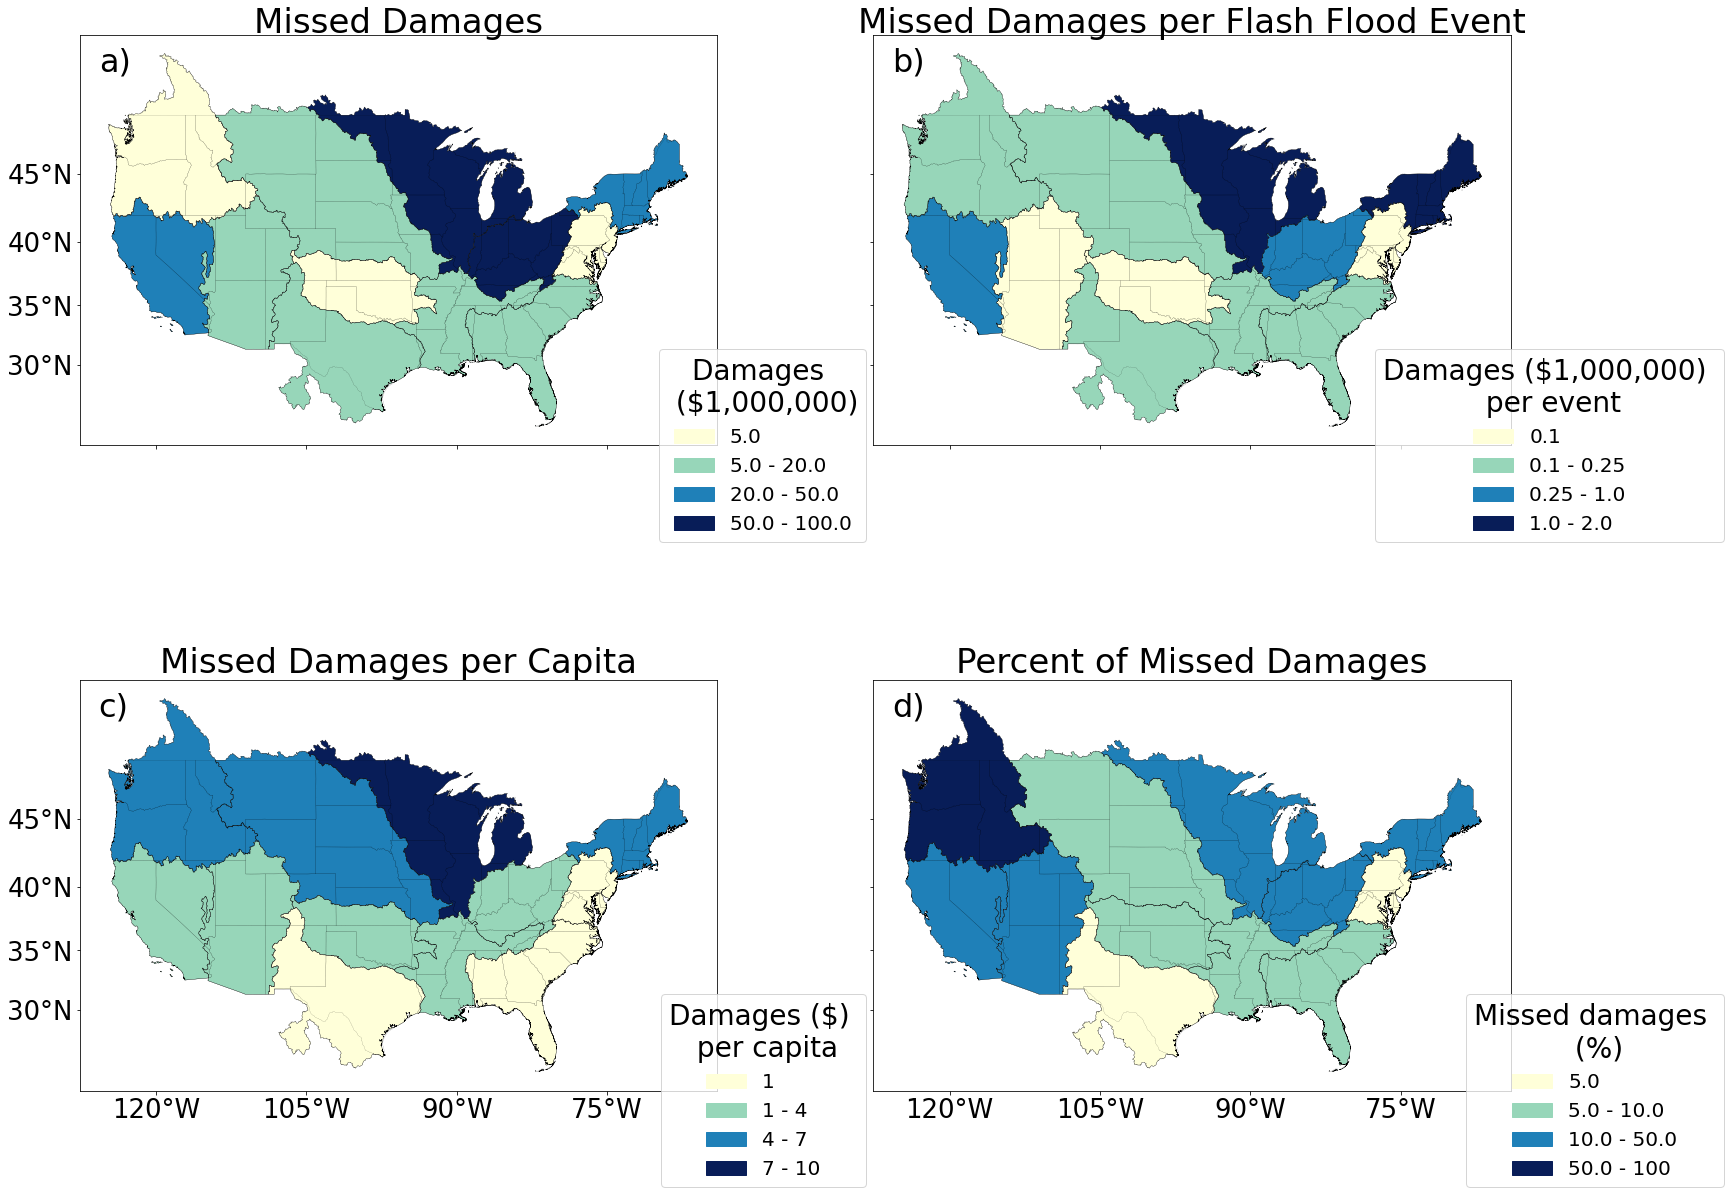

In [208]:
risk_levels_dict={'property_d':'Missed Damages',
                      #'property_d_y':'Number of Damaging Missed Flash Flood Events',
                      'damage_per_event':'Missed Damages per Flash Flood Event',
                      'dp_select_counties':'Missed Damages per Capita',
                 'damage_percent':'Percent of Missed Damages'}
        
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(24,18),sharey=True,sharex=True)

for risk_level,ax,label in zip(risk_levels_dict,axes.flat,subplot_labels):
    
    if risk_level=='property_d':
        bins_list=[5000000,20000000,50000000,100000000]
#     if risk_level=='property_d_y':
#         bins_list=[20,60,100,140,180]
    if risk_level=='damage_per_event':
        bins_list=[100000,250000,1000000,2000000]
    if risk_level=='dp_select_counties':    
        bins_list=[1,4,7,10]
    if risk_level=='damage_percent':
        bins_list=[0.05,0.10,0.5,1]

    bins_dict={'bins':bins_list}

    evenly_spaced_interval = np.linspace(0, 1, len(bins_list))
    LegendElement=[]
    colors = [cm.YlGnBu(x) for x in evenly_spaced_interval]
    
    if risk_level=='property_d' or risk_level=='damage_per_event':
        for i,name in zip(range(len(colors)),bins_list):
            if name==bins_list[0]:
                LegendElement.append(mpatches.Patch(color=colors[i],label=str(name/1000000)))
            else:
                LegendElement.append(mpatches.Patch(color=colors[i],label=str(bins_list[i-1]/1000000)+" - "+str((name/1000000))))
    
    elif risk_level=='damage_percent':
        for i,name in zip(range(len(colors)),bins_list):
            if name==bins_list[0]:
                LegendElement.append(mpatches.Patch(color=colors[i],label=str(name*100)))
            else:
                LegendElement.append(mpatches.Patch(color=colors[i],label=str(bins_list[i-1]*100)+" - "+str((name*100))))
    
    else:
        for i,name in zip(range(len(colors)),bins_list):
            if name==bins_list[0]:
                LegendElement.append(mpatches.Patch(color=colors[i],label=str(name)))
            else:
                LegendElement.append(mpatches.Patch(color=colors[i],label=str(bins_list[i-1])+" - "+str((name))))
        
        
    #fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(18,10),sharey=True,sharex=True)


    #set title, set ticks, change ticks to lat/lon
    ax.set_title(risk_levels_dict[risk_level])
    ax.set_xticks(x_meters)
    ax.set_xticklabels(y_latlon_str)
    ax.set_yticks(y_meters)
    ax.set_yticklabels(x_latlon_str)    

    #read file

# for risk_function(risk_levels_dict)

    if risk_level=='property_d':
        riv_merge.plot('property_d',ax=ax,edgecolor="none",linewidth=0.1,
                              cmap=ListedColormap(colors),zorder=2,
                             scheme='UserDefined',classification_kwds=bins_dict)
        l=ax.legend(handles = LegendElement, loc='right',bbox_to_anchor=[1.25, 0],
               title='Damages \n ($1,000,000)')
        print(max(riv_merge['property_d']),min(riv_merge['property_d']))

#     elif risk_level =='property_d_y':
#         riv_merge.plot('property_d_y',ax=ax,edgecolor="none",linewidth=0.1,
#                               cmap=ListedColormap(colors),zorder=2,#legend=True
#                              scheme='UserDefined',classification_kwds=bins_dict)
#         l=ax.legend(handles = LegendElement,fontsize=16, loc='right',bbox_to_anchor=[1.05, 0],
#                title='Damaging Events')

    elif risk_level=='damage_per_event':
        riv_merge.plot('damage_per_event',ax=ax,edgecolor="none",linewidth=0.1,
                              cmap=ListedColormap(colors),zorder=2,#legend=True
                               scheme='UserDefined',classification_kwds=bins_dict)
        l=ax.legend(handles = LegendElement, loc='right',bbox_to_anchor=[1.35, 0],
               title='Damages ($1,000,000) \n per event')
        print(max(riv_merge['damage_per_event']),min(riv_merge['damage_per_event']))

    elif risk_level=='dp_select_counties':
        riv_merge.plot('dp_select_counties',ax=ax,edgecolor="none",linewidth=0.1,
                              cmap=ListedColormap(colors),zorder=2,#legend=True
                               scheme='UserDefined',classification_kwds=bins_dict)
        l=ax.legend(handles = LegendElement, loc='right',bbox_to_anchor=[1.25, 0],
               title='Damages ($) \n per capita')
        print(max(riv_merge['dp_select_counties']),min(riv_merge['dp_select_counties']))
        

    elif risk_level=='damage_percent':
        riv_merge.plot('damage_percent',ax=ax,edgecolor="none",linewidth=0.1,
                              cmap=ListedColormap(colors),zorder=2,#legend=True
                               scheme='UserDefined',classification_kwds=bins_dict)
        l=ax.legend(handles = LegendElement, loc='right',bbox_to_anchor=[1.35, 0],
               title='Missed damages \n (%)')
        print(max(riv_merge['damage_percent']),min(riv_merge['damage_percent']))
        
    river.plot(ax=ax,color='none',edgecolor='black',linewidth=0.3,zorder=3)

    states.plot(ax=ax,color='none',edgecolor='black',linewidth=0.1,zorder=2)
    ax.text(0.03, 0.97, label, transform=ax.transAxes,
      fontsize=32, va='top')


#     l=ax.legend(handles = LegendElement,fontsize=16, loc='right',bbox_to_anchor=[1.75, 0],
#                title='Damages ($1,000,000) \n per capita') 
    plt.setp(l.get_title(), multialignment='center')

plt.tight_layout()
fig.savefig(r'/blue/emullens/meirahwilliamson/figures/rfc_4_panel.png',bbox_extra_artists=(l,), bbox_inches='tight',dpi=300)

In [209]:
fig.savefig(r'/blue/emullens/meirahwilliamson/figures/rfc_4_panel.png',bbox_extra_artists=(l,), bbox_inches='tight',dpi=300)

In [181]:
CBRFC=missed[(missed['BASIN_ID']=='CBRFC')].dropna()
CNRFC=missed[(missed['BASIN_ID']=='CNRFC')].dropna()
#ugh=other[(other['BASIN_ID']=='CNRFC')]


group_CBRFC=CBRFC.groupby('episode_id').agg({'property_d':'sum', 'episode_na':'first','GEOID':'first','date':'first','flood_caus':'first'})
group_CNRFC=CNRFC.groupby('episode_id').agg({'property_d':'sum', 'episode_na':'first','GEOID':'first','date':'first','flood_caus':'first'})


print('monsoon ',len(CBRFC[(CBRFC['episode_na'].str.contains('monsoon|Monsoon|southerly|Southerly|last push of moisture|Last push of moisture'))
                     |((CBRFC['date']>20170700)&(CBRFC['date']<20170900))
                      |((CBRFC['date']>20180700)&(CBRFC['date']<20180900))
                     |((CBRFC['date']>20190700)&(CBRFC['date']<20190900))
                     |((CBRFC['date']>20200700)&(CBRFC['date']<20200900))]['property_d']),CBRFC[CBRFC['episode_na'].str.contains(('monsoon|Monsoon|southerly|Southerly|last push of moisture|Last push of moisture'))
                    |((CBRFC['date']>20170700)&(CBRFC['date']<20170900))
                      |((CBRFC['date']>20180700)&(CBRFC['date']<20180900))
                     |((CBRFC['date']>20190700)&(CBRFC['date']<20190900))
                     |((CBRFC['date']>20200700)&(CBRFC['date']<20200900))]['property_d'].sum())
print('hurricane ', len(CBRFC[CBRFC['episode_na'].str.contains('hurricane|Hurricane|Tropical|tropical')]),CBRFC[CBRFC['episode_na'].str.contains('hurricane|Hurricane|Tropical|tropical')]['property_d'].sum())
print('ar ',len(CBRFC[CBRFC['episode_na'].str.contains('atmospheric river|Atmospheric')]['property_d']),CBRFC[CBRFC['episode_na'].str.contains('atmospheric river')]['property_d'].sum())


print(len(CBRFC),CBRFC['property_d'].sum())

print('---')

print('monsoon ',len(CNRFC[CNRFC['episode_na'].str.contains('monsoon|Monsoon|southerly|Southerly|last push of moisture|Last push of moisture')]['property_d']),CNRFC[CNRFC['episode_na'].str.contains('monsoon|Monsoon|southerly|Southerly|last push of moisture|Last push of moisture')]['property_d'].sum())
print('hurricane ',len(CNRFC[CNRFC['episode_na'].str.contains('hurricane|Hurricane|Tropical|tropical')]),CNRFC[CNRFC['episode_na'].str.contains('hurricane|Hurricane|Tropical|tropical')]['property_d'].sum())
print('ar ',len(CNRFC[CNRFC['episode_na'].str.contains('atmospheric river|Atmospheric')]['property_d']),CNRFC[CNRFC['episode_na'].str.contains('atmospheric river')]['property_d'].sum())

print(len(CNRFC),CNRFC['property_d'].sum())

monsoon  72 9011500.0
hurricane  4 208000.0
ar  2 7000.0
103 10074500.0
---
monsoon  44 12171500.0
hurricane  9 2970000.0
ar  3 5187000.0
83 23792000.0


In [93]:
CBRFC=all_damages[(all_damages['BASIN_ID']=='CBRFC')].dropna()
CNRFC=all_damages[(all_damages['BASIN_ID']=='CNRFC')].dropna()
#ugh=other[(other['BASIN_ID']=='CNRFC')]


group_CBRFC=CBRFC.groupby('episode_id').agg({'property_d':'sum', 'episode_na':'first','GEOID':'first','date':'first','flood_caus':'first'})
group_CNRFC=CNRFC.groupby('episode_id').agg({'property_d':'sum', 'episode_na':'first','GEOID':'first','date':'first','flood_caus':'first'})


print('monsoon ',len(CBRFC[(CBRFC['episode_na'].str.contains('monsoon|Monsoon|southerly|Southerly|last push of moisture|Last push of moisture'))
                     |((CBRFC['date']>20170700)&(CBRFC['date']<20170900))
                      |((CBRFC['date']>20180700)&(CBRFC['date']<20180900))
                     |((CBRFC['date']>20190700)&(CBRFC['date']<20190900))
                     |((CBRFC['date']>20200700)&(CBRFC['date']<20200900))]['property_d']),CBRFC[CBRFC['episode_na'].str.contains(('monsoon|Monsoon|southerly|Southerly|last push of moisture|Last push of moisture'))
                    |((CBRFC['date']>20170700)&(CBRFC['date']<20170900))
                      |((CBRFC['date']>20180700)&(CBRFC['date']<20180900))
                     |((CBRFC['date']>20190700)&(CBRFC['date']<20190900))
                     |((CBRFC['date']>20200700)&(CBRFC['date']<20200900))]['property_d'].sum())
print('hurricane ', len(CBRFC[CBRFC['episode_na'].str.contains('hurricane|Hurricane|Tropical|tropical')]),CBRFC[CBRFC['episode_na'].str.contains('hurricane|Hurricane|Tropical|tropical')]['property_d'].sum())
print('ar ',len(CBRFC[CBRFC['episode_na'].str.contains('atmospheric river|Atmospheric')]['property_d']),CBRFC[CBRFC['episode_na'].str.contains('atmospheric river')]['property_d'].sum())


print(len(CBRFC),CBRFC['property_d'].sum())

print('---')

print('monsoon ',len(CNRFC[CNRFC['episode_na'].str.contains('monsoon|Monsoon|southerly|Southerly|last push of moisture|Last push of moisture')]['property_d']),CNRFC[CNRFC['episode_na'].str.contains('monsoon|Monsoon|southerly|Southerly|last push of moisture|Last push of moisture')]['property_d'].sum())
print('hurricane ',len(CNRFC[CNRFC['episode_na'].str.contains('hurricane|Hurricane|Tropical|tropical')]),CNRFC[CNRFC['episode_na'].str.contains('hurricane|Hurricane|Tropical|tropical')]['property_d'].sum())
print('ar ',len(CNRFC[CNRFC['episode_na'].str.contains('atmospheric river|Atmospheric')]['property_d']),CNRFC[CNRFC['episode_na'].str.contains('atmospheric river')]['property_d'].sum())

print(len(CNRFC),CNRFC['property_d'].sum())

monsoon  72 9011500.0
hurricane  4 208000.0
ar  2 7000.0
103 10074500.0
---
monsoon  44 12171500.0
hurricane  9 2970000.0
ar  3 5187000.0
83 23792000.0
